### The Quantization Module

- quantization is used to create targets in self-supervised learning.

- Idea : To enable masked pretraining, turn the dense representations $Z$, which are part of a *continous* sequence into a discrete representation, where there is a fixed number of possible representation ($q_t$) for each $z_t$, as opposed to infinite in the continous case. I guess thats why BERT works out of the box : there is only a finite amount of words that can be softmaxxed over at each $t$.



##  - - - - -  W2V2  - - - - - 

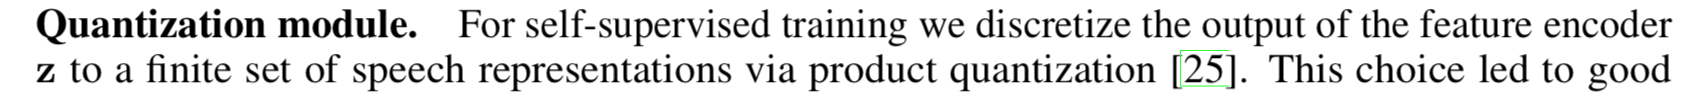
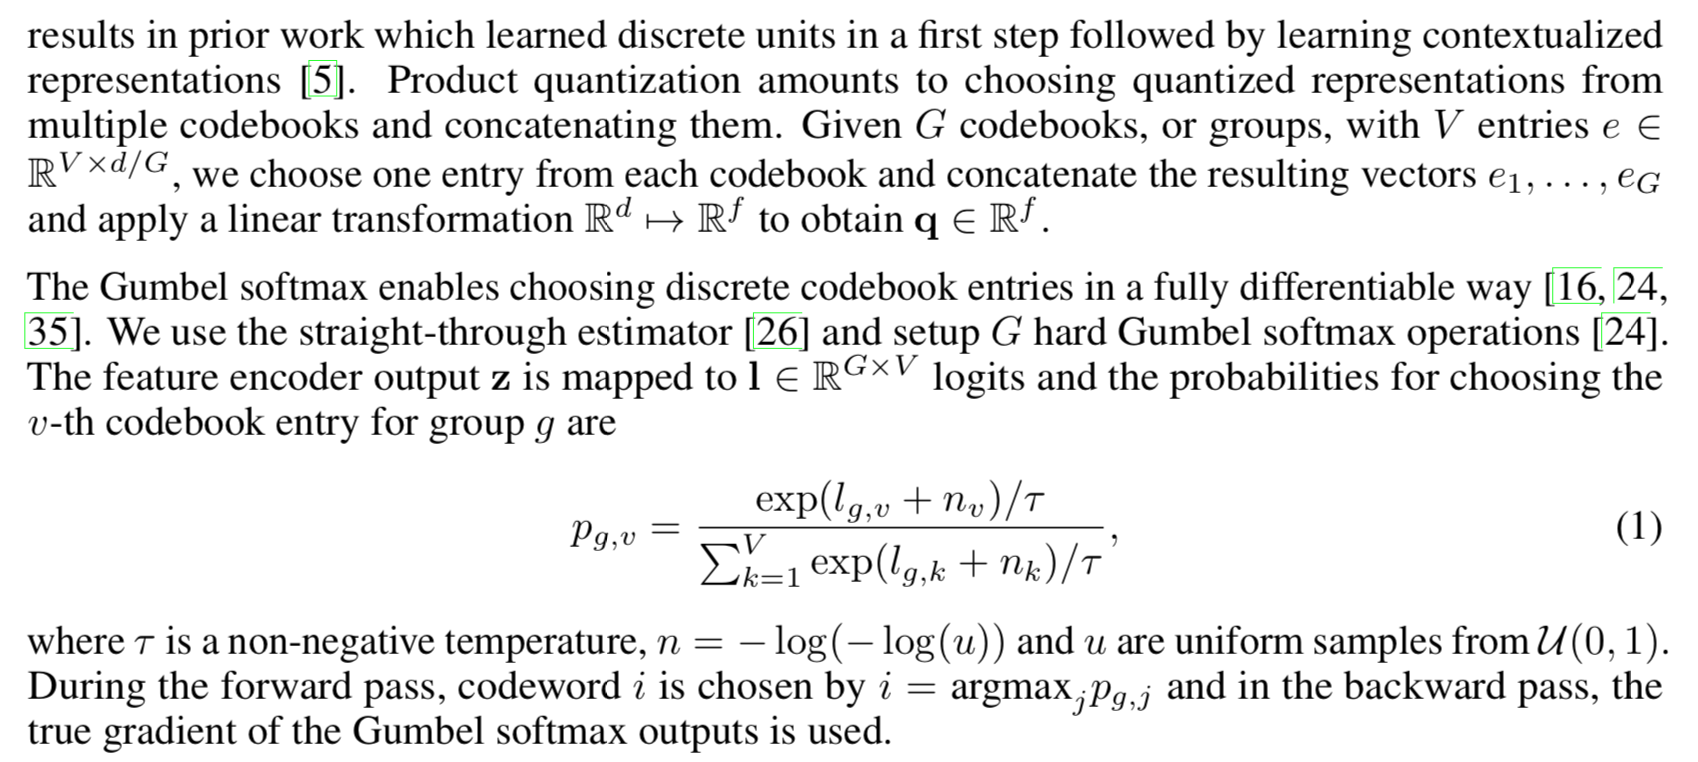

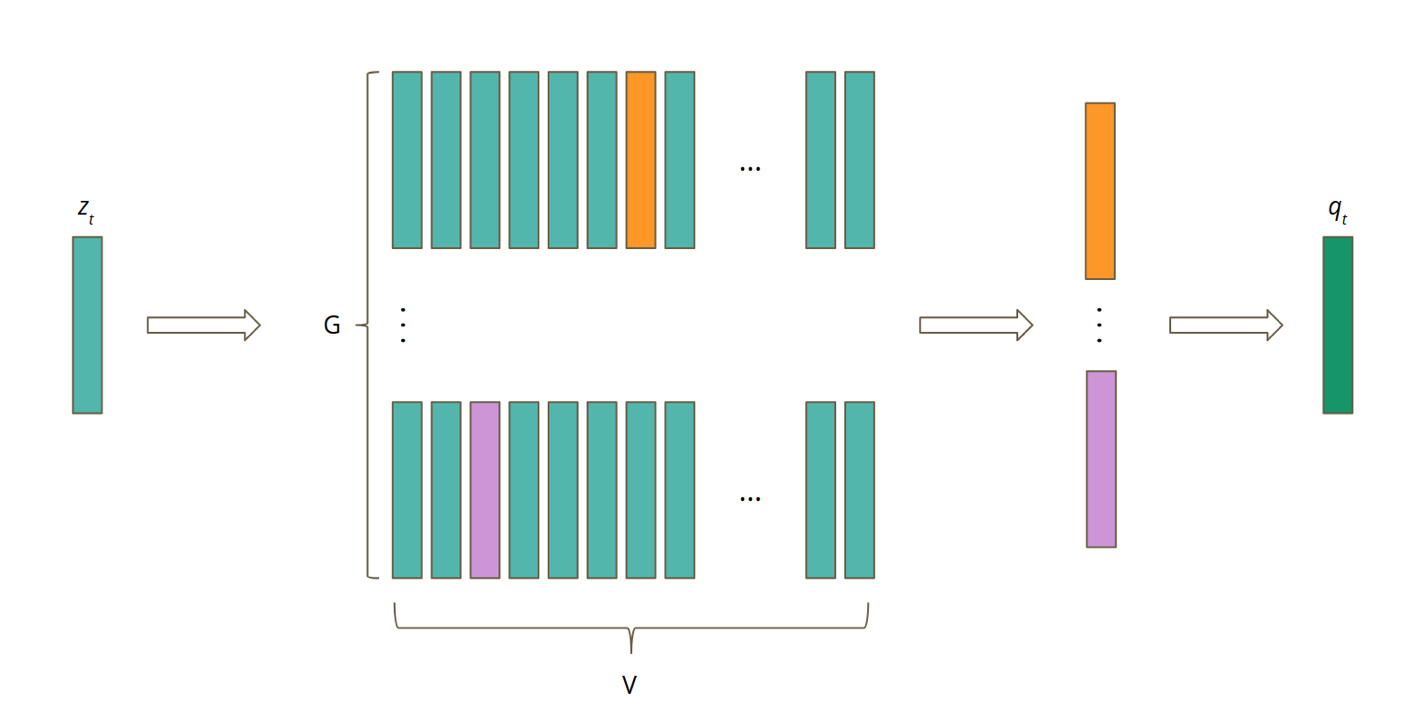

For each of the $G$ codebooks, we choose an item according to
$$
p_{g, v}=\frac{\exp \left(\operatorname{sim}\left(l_{g, v}+n_{v}\right) / \tau\right)}{\sum_{k=1}^{V} \exp \left(\left(l_{g, k}+n_{k}\right) / \tau\right)}
$$



- $ l \in \mathcal{R}^{G \times V}$, logits calculated from z

- $n_{k} = -log(-log(u_{k})), u_{k} ~ U$

representing a classification task.

" *Why, in our case, is Gumbel softmax better than a normal softmax? It comes with two improvements: randomization and temperature 𝜏. Due to randomization, the model is more willing to choose different code words during training and then to update their weights. It is important, especially in the beginning of training, to prevent using only a subset of codebooks. The temperature is lowered over time from 2 to 0.5, so the impact of randomization is getting smaller with time.* "



### The objective

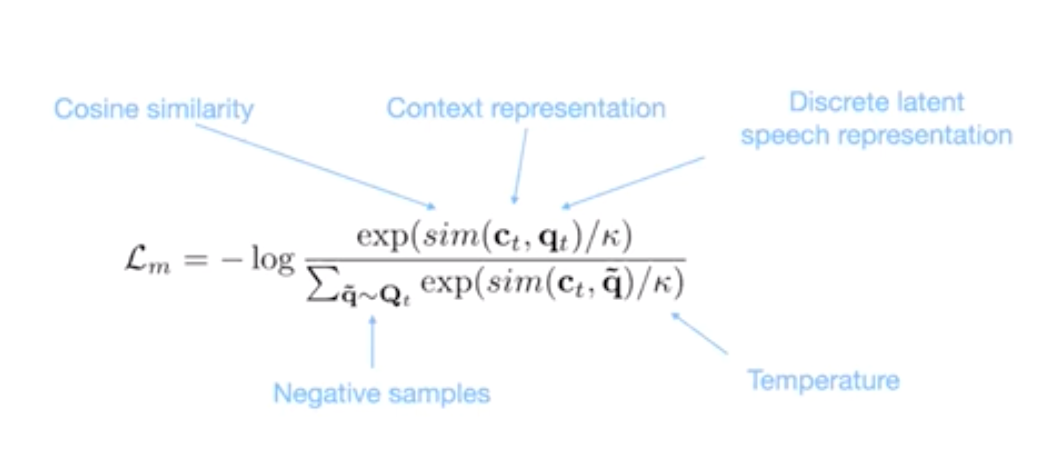

Excellent resource : https://neurosys.com/article/wav2vec-2-0-a-framework-for-self-supervised-learning-of-speech-representations/

## Contrastive Loss

Examplified

In [47]:
import numpy as np
# initial point
p1 = np.array([-0.83483301, -0.16904167, 0.52390721])

# compare with those vectors:
P = np.array([
    # similar point
 [-0.83455951, -0.16862266, 0.52447767],
    # distractors
 [ 0.70374682, -0.18682394, -0.68544673],
 [ 0.15465702,  0.32303224,  0.93366556],
 [ 0.53043332, -0.83523217, -0.14500935],
 [ 0.68285685, -0.73054075,  0.00409143],
 [ 0.76652431,  0.61500886,  0.18494479]])

In order to measure how similar two vectors are to each other, we need a way of measuring distance. In 2 or 3 dimensions the euclidian distance (“ordinary” or straight-line distance) is a great choice for measuring the distance between two points. However, in a large dimensional space, all points tend to be far apart by the euclidian measure. In higher dimensions, the angle between vectors is a more effective measure. The cosine distance measures the cosine of the angle between the vectors. The cosine of identical vectors is 1 while orthogonal and opposite vectors are 0 and -1 respectively. More similar vectors will result in a larger number. Calculating the cosine distance is done by taking the dot product of the vectors.

- cos_sim = $ x_i @ x_j$
- 1 if $x_i = x_j$
- 0 if orthog.($x_i, x_j$)
- -1 if oppos.($x_i, x_j$)

In [48]:
# collect the distances
%time
sims = np.array([p1@p_j for p_j in P])

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 28.1 µs


In [49]:
# Better : use linear algebra instead of for loop
%time
sims = p1@P.T

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.01 µs


In [50]:
(p1@P.T)[0] == p1.T@P[0] == p1@P[0] == p1@P[0].T

True

### Softmax the distances

When calculating the loss for categorical cross-entropy, the first step is to take the softmax of the values, then the negative log of the labeled category.

$$
s(x_i) = \frac{exp(x_i)}{\sum_{j} exp(x_j)}
$$

In [51]:
softmax = np.exp(sims) / np.exp(sims).sum()

In [52]:
softmax

array([0.42967915, 0.06330716, 0.21453534, 0.10835722, 0.10135234,
       0.08276879])

### Cross Entropy Loss

Given $C$ categories, first obtain the softmax :

$$
s(x_i) = \frac{exp(x_i)}{\sum_{j}^{C} exp(x_j)}
$$


$$
C E=-\sum_{i}^{C} t_{i} \log \left(s(x_{i})\right)
$$

### Contrastive Loss


Contrastive loss looks suspiciously like the softmax function. That’s because it is, with the addition of the vector similarity and a temperature normalization factor. The similarity function is just the cosine distance that we talked about before. The other difference is that values in the denominator are the cosign distance from the positive example to the negative samples. Not very different from CrossEntropyLoss. The intuition here is that we want our similar vectors to be as close to 1 as possible, since -log(1) = 0, that’s the optimal loss. We want the negative examples to be close to 0 , since any non-zero values will reduce the value of similar vectors.

$$
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_{i}, \boldsymbol{z}_{j}\right) / \tau\right)}{\sum_{k=1}^{2 N}{ }_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_{i}, \boldsymbol{z}_{k}\right) / \tau\right)}
$$

In [55]:
temp = 0.07

In [58]:
logits = sims/temp
logits = np.exp(logits)

In [60]:
loss = - np.log(logits[0] / logits.sum())

In [61]:
loss

4.9068650660314756e-05